In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
import pandas as pd
data = pd.read_csv('/content/task_3_event_prediction.tsv', sep = '\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

In [ ]:
counts = data.groupby(['EVENT_DATE']).size()
data = data[data['EVENT_DATE'].notna()]
data = data.reset_index(drop=True)
newdata = data.drop_duplicates(subset=['EVENT_DATE'])
newdata['unrests'] = 0
newdata = newdata.reset_index(drop=True)
for i in range(len(newdata)):  
    newdata['unrests'][i] = counts[newdata['EVENT_DATE'][i]]
newdata = pd.concat([newdata['EVENT_DATE'], newdata['unrests']], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
newdata.head()

,EVENT_DATE,unrests
0,01-January-2018,30
1,02-January-2018,55
2,03-January-2018,80
3,04-January-2018,34
4,05-January-2018,38


In [ ]:
data = data[data['EVENT_DATE'].notna()]
data = data.reset_index(drop=True)
data = data[data.EVENT_DATE != 'usa']
data['EVENT_DATE'] = pd.to_datetime(data['EVENT_DATE'])

In [ ]:
new = data.groupby(['EVENT_DATE','ADMIN1']).size().reset_index()
new = new.sort_values(by=['EVENT_DATE'], ascending=True)
new.rename(columns = {'ADMIN1':'Location', 0 :'Unrests'}, inplace = True)
new = new.reset_index(drop=True)
new["Location"] = new["Location"].astype('category')
new["Location_codes"] = new["Location"].cat.codes

In [ ]:
new[:5]

,EVENT_DATE,Location,Unrests,Location_codes
0,2018-01-01,Bihar,1,8
1,2018-01-01,Telangana,1,73
2,2018-01-01,Punjab,6,66
3,2018-01-01,Manipur,2,41
4,2018-01-01,Maharashtra,1,39


In [ ]:
new_data1 = new.drop('EVENT_DATE', 1)
new_data1 = new_data1.reset_index(drop=True)
new_data1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Location,Unrests,Location_codes
0,Bihar,1,8
1,Telangana,1,73
2,Punjab,6,66
3,Manipur,2,41
4,Maharashtra,1,39


In [ ]:
new_data1 = new_data1.drop('Location', 1)
new_data1 = new_data1.reset_index(drop=True)
new_data1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Unrests,Location_codes
0,1,8
1,1,73
2,6,66
3,2,41
4,1,39


In [ ]:
# For this case, let's assume that
# Given past 15 days observation, forecast the next 5 days observations. 
n_past = 15
n_future = 5
n_features = 2

In [ ]:
len(new_data1) * 0.75

29439.0

Train - Test Split

In [ ]:
train_df, test_df = new_data1[:29439], new_data1[29439:]  # 75% and 25%
train_df.shape,test_df.shape

((29439, 2), (9813, 2))

In [ ]:
train = train_df


test = test_df

In [ ]:
train.values

**Converting the series to samples for supervised learning**

In [ ]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [ ]:
X_train.shape

(29420, 15, 2)

In [ ]:
X_test.shape

(9794, 15, 2)

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 15, 2)]      0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 15, 100),    41200       ['input_6[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_15 (LSTM)                 [(None, 100),        80400       ['lstm_14[0][0]']                
                                 (None, 100),                                               

 **Training the models**


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

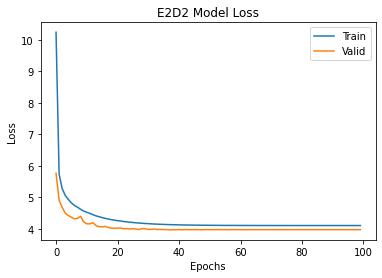

In [ ]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Prediction on validation set

In [ ]:
pred1_e2d2=model_e2d2.predict(X_test)

In [ ]:
pred1_e2d2 = np.trunc(pred1_e2d2)


In [ ]:
pred1_e2d2[2:4]

array([[[ 1.,  2.],
        [ 2.,  5.],
        [ 2.,  7.],
        [ 1.,  8.],
        [ 1., 11.]],

       [[ 2.,  6.],
        [ 2.,  8.],
        [ 1., 10.],
        [ 1., 12.],
        [ 1., 15.]]], dtype=float32)

In [ ]:
y_test[2:4]

array([[[ 1,  5],
        [15,  9],
        [ 1, 10],
        [ 1, 11],
        [ 4, 13]],

       [[15,  9],
        [ 1, 10],
        [ 1, 11],
        [ 4, 13],
        [ 3, 17]]])

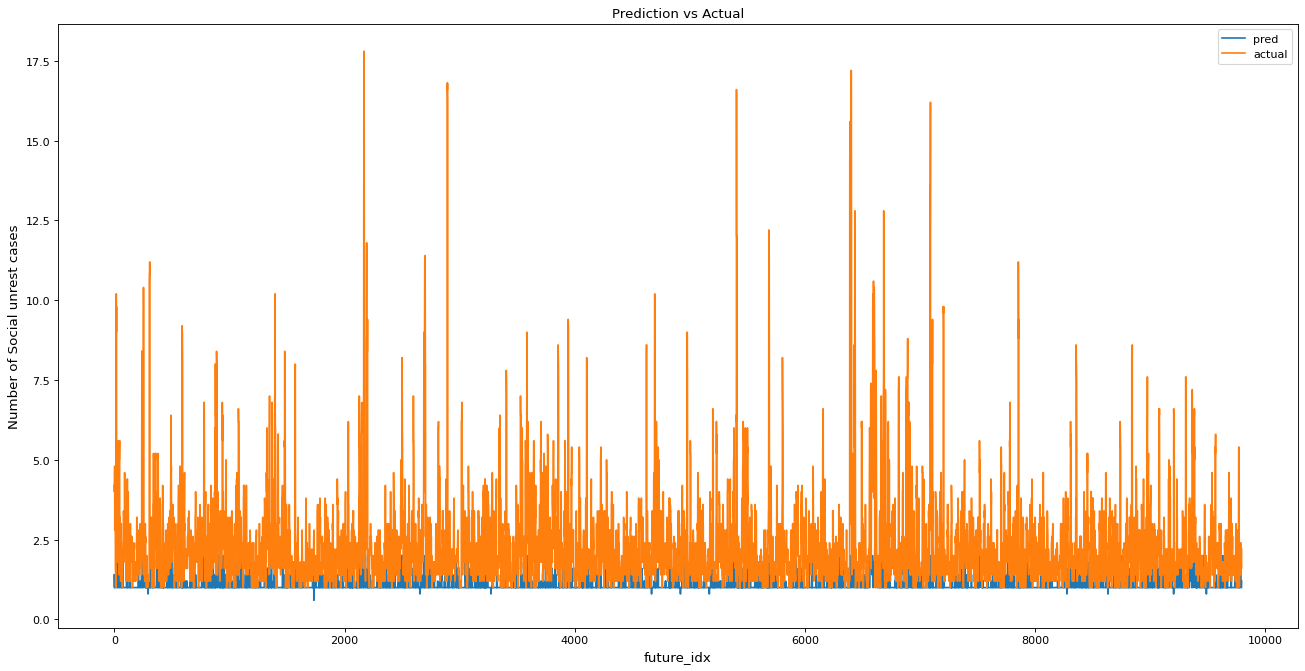

In [ ]:
predicted_unrests = []
actual_unrests = []
predicted_locations = []
actual_locations = []
for i in range(len(pred1_e2d2)):

    T1 = []
    P1 = []
    T2 = []
    P2 = []
    for j in y_test[i]:
        T1.append(j[0].item())
        T2.append(j[1].item())
    
    for k in pred1_e2d2[i]:
        P1.append(k[0].item())
        P2.append(k[1].item())
    
    predicted_unrests.append(np.mean(P1))
    predicted_locations.append(np.mean(P2))

    actual_unrests.append(np.mean(T1))
    actual_locations.append(np.mean(T2))

figure(figsize=(20, 10), dpi=80)
plt.plot(predicted_unrests, label = "pred")
plt.plot(actual_unrests, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Number of Social unrest cases", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()

# figure(figsize=(20, 10), dpi=80)
# plt.plot(predicted_locations, label = "pred")
# plt.plot(actual_locations, label = "actual")
# plt.title("Prediction vs Actual")
# plt.ylabel("Number of Social unrest cases", fontsize=12)
# plt.xlabel("future_idx", fontsize=12)
# plt.legend()